# Computing Coursework 2024
Michael Pan (01853189), Joshua Chong (02125958)

<h3>Importing Libraries</h3>

In [173]:
# make sure required libraries are installed
%pip install numpy matplotlib
%matplotlib inline

# In this section I am importing all the libraries I will need
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


### Black-Scholes Equation
The Black-Scholes equation for options value is defined by
$$ \frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S} - rV = 0 $$
where $V$ is price of the call option, $S$ is price of the underlying stock, $t$ is the time in years, $r$ is the risk-free interest rate, and $\sigma$ is the volatility of the underlying stock price. 

To solve this PDE numerically, we transformed it into the form of the heat diffusion equation 
$$ \frac{\partial u}{\partial \tau} = \frac{\sigma^2}{2}\frac{\partial^2 u}{\partial x^2} $$
using the transformations
$$ \tau = T - t $$
$$ x = \ln{\frac{S}{K}} $$
$$ u(x, \tau) = Ve^{\alpha x + \beta \tau} $$
where 
$$ \alpha = \frac{r}{\sigma^2}-\frac{1}{2} $$
$$ \beta = \frac{r^2}{2\sigma^2} + \frac{r}{2} + \frac{\sigma^2}{8} $$

### Setting Constants

In [174]:
# Expiration time in years
T = 1
# Strike price 
K = 50
# Risk-free interest rate
r = 0.05
# Volatility of stock price
sigma = 0.2


#coefficients of u
alpha = (r/(sigma**2)) - 0.5
beta = (r**2 / (2 * sigma**2)) + (r / 2) + (sigma**2 / 8)

# sigma^2 / 2
sigma2 = sigma**2 / 2


### Discretised Grid

In [175]:
# In this section I am setting the domain of solution and the discretised grid
# The domain of x
L = 1
h = 0.1     # step size


# The domain of tau
T = 5 
p = 0.005     # step size


# function takes in the domain of x xi, the step size hi, the domain of tau ti and the step size pi and returns the discretised grid
def grid(xi,hi,ti,pi):
    # initialising discretised grid
    x = np.arange(-xi,xi+hi,hi)
    tau = np.arange(0,ti+pi,pi)
    return x,tau

x, tau = grid(L,h,T,p)
n = len(x)
m = len(tau)
print(n,m)

21 1001


In [176]:
# In this section I am defining arrays I would need (if neeeded)
# initialising the solution matrix u(tau, x)
u = np.zeros((int(m),int(n)))




### Boundary Conditions
The non-transformed boundary conditions are 
$$ V(0,t) = 0 $$
$$ V(\infty, t) = S - Ke^{-r(T-t)} $$
with an end condition of
$$ V(S,T) = max\{S-K, 0\} $$

After the transformation into the heat equation form, the boundary and end conditions are transformed to
$$ u(-L,\tau) = 0 $$
$$ u(L,\tau) = e^{\alpha L + \beta \tau}(Ke^L-Ke^{-r\tau}) $$
$$ u(x,0) = e^{\alpha x} * max\{Ke^x-K,0\} $$

In [177]:
# In this section I am setting the boundary conditions/initial values
def boundary_conditions(u,x,tau):
    # setting the initial condition at tau = 0
    u[0,:] = np.maximum(np.exp(x)*K - K,0)*np.exp(alpha*x)
    # setting the boundary condition at x = -L
    u[:,0] = 0
    # setting the boundary condition at x = L
    u[:,-1] = np.exp(alpha*x[-1] + beta*tau) * (np.exp(x[-1])*K - K*np.exp(-r*tau))
    return u

u = boundary_conditions(u,x,tau)
print(u)

[[  0.           0.           0.         ... 111.65405832 143.33543211
  181.88013297]
 [  0.           0.           0.         ...   0.           0.
  181.96230959]
 [  0.           0.           0.         ...   0.           0.
  182.04451286]
 ...
 [  0.           0.           0.         ...   0.           0.
  278.62870649]
 [  0.           0.           0.         ...   0.           0.
  278.7420452 ]
 [  0.           0.           0.         ...   0.           0.
  278.8554202 ]]


### Numerical Method

#### Explicit Solution
Forward in time, central in space

In [178]:
# In this section I am implementing the numerical method using an explicit finite difference scheme
# explicit takes in matrix u, the number of rows m and the number of columns n and returns the solution matrix
def explicit(u,m,n,p,h):
    # initialise explicit solution matrix
    u_explicit = u.copy()
    # populating the solution matrix from second row to last row
    for i in range(m-1):        # looping through tau
        for j in range(1,n-1):    # looping through x
            u_explicit[i+1,j] = u_explicit[i,j] + ((sigma2*p/(h**2)) * (u_explicit[i,j+1] - 2*u_explicit[i,j] + u_explicit[i,j-1]))
    return u_explicit
u_explicit = explicit(u,m,n,p,h)


#### Implicit Solution
Crank-Nicolson Method

In [179]:
#In this section I am implementing the numerical method using an implicit finite difference scheme
# implicit takes in matrix u, the number of rows m and the number of columns n and returns the solution matrix
def implicit(u,m,n,p,h):
    # initialise implicit solution matrix
    u_implicit = u.copy()
    # diagonal coefficient
    a = (1 + (sigma2*p/h**2))
    # upper and lower diagonal coefficient
    b = -sigma2*p/(2*h**2)
    for i in range(1,m):       # looping through tau
        # initialise tridiagonal matrix A
        A = np.zeros((n-2,n-2))
        # initialise known solution matrix C
        C = np.zeros((n-2,1))
        
        C[0,0] = -b*(u_implicit[i-1,0]+u_implicit[i-1,2]-2*u_implicit[i-1,1]) + u_implicit[i-1,1] - b*u_implicit[i,0]
        C[-1,0] = -b*(u_implicit[i-1,-1]+u_implicit[i-1,-3]-2*u_implicit[i-1,-2]) + u_implicit[i-1,-2] - b*u_implicit[i,-1]
        A[0,:2] = [a,b]
        A[-1,-2:] = [b,a]
        # populate A and C
        for j in range(1,n-3):
            A[j,j-1] = b
            A[j,j] = a
            A[j,j+1] = b         
            C[j,0] = -b*(u_implicit[i-1,j-1]+u_implicit[i-1,j+1]-2*u_implicit[i-1,j]) + u_implicit[i-1,j]
        
        # solve for u(tau_i, x)
        B = np.linalg.solve(A,C)
        u_implicit[i,1:-1] = B.flatten()

    return u_implicit

u_implicit = implicit(u,m,n,p,h)
    


[[ 1.01  -0.005  0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [-0.005  1.01  -0.005  0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.005  1.01  -0.005  0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.005  1.01  -0.005  0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.005  1.01  -0.005  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.005  1.01  -0.005  0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.005  1.01  -0.005  0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.005  1.0

### Result Plotting

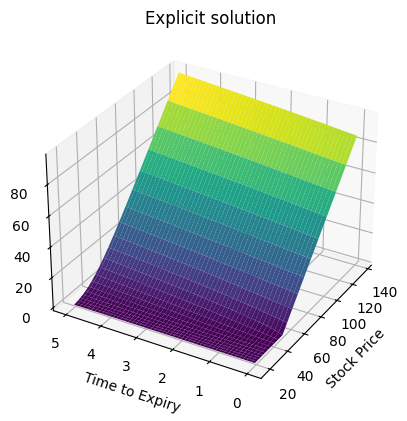

In [180]:
# In this section I am showing the results
# Convert the solutions into options value
v_explicit = np.zeros((m,n))
v_implicit = np.zeros((m,n))
v = np.zeros((m,n))
for i in range(m):
    v_explicit[i] = u_explicit[i] / np.exp(alpha*x+beta*tau[i])
    v_implicit[i] = u_implicit[i] / np.exp(alpha*x+beta*tau[i])
    v[i] = u[i] / np.exp(alpha*x+beta*tau[i])
# convert x domain into stock price
S = K * np.exp(x)
s_grid, tau_grid = np.meshgrid(S,tau)


# surface plot of the explicit solution
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(s_grid,tau_grid,v_explicit,cmap='viridis')
# ax.set_title('Explicit solution')
# ax.set_xlabel('Stock Price')
# ax.set_ylabel('Time to Expiration')
# ax.set_zlabel('Option Value')
# plt.show()
def surface_plot(value, fig=None, ax=None):
    """returns a surface plot of the value of the option"""
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(s_grid, tau_grid, value, cmap="viridis")
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Time to Expiry")
    ax.set_zlabel("Option Price")
    ax.view_init(30, -150)
    return fig, ax

fig, ax = surface_plot(v_explicit)
ax.set_title("Explicit solution")
plt.show()


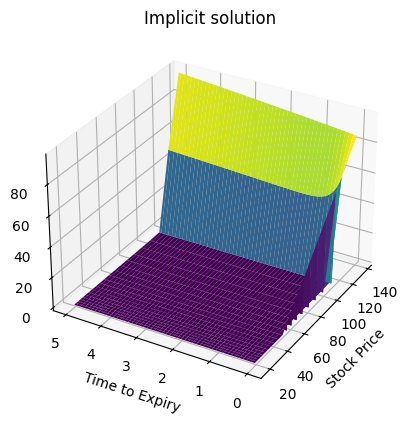

In [181]:
# surface plot of the implicit solution
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(s_grid,tau_grid,v_implicit,cmap='viridis')
fig, ax = surface_plot(v_implicit)
ax.set_title('Implicit solution')
# ax.set_xlabel('Stock Price')
# ax.set_ylabel('Time to Expiration')
# ax.set_zlabel('Option Value')
plt.show()

### THE END
𝅘𝅥𝅮 celebrate good time come on 𝅘𝅥𝅮

In [182]:
# In this section I am celebrating
print('CW done: I deserve a good mark')

CW done: I deserve a good mark
